# Homework and bake-off: pragmatic color descriptions

In [ ]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Summer 2021"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [All two-word examples as a dev corpus](#All-two-word-examples-as-a-dev-corpus)
1. [Dev dataset](#Dev-dataset)
1. [Random train–test split for development](#Random-train–test-split-for-development)
1. [Question 1: Improve the tokenizer [1 point]](#Question-1:-Improve-the-tokenizer-[1-point])
1. [Use the tokenizer](#Use-the-tokenizer)
1. [Question 2: Improve the color representations [1 point]](#Question-2:-Improve-the-color-representations-[1-point])
1. [Use the color representer](#Use-the-color-representer)
1. [Initial model](#Initial-model)
1. [Question 3: GloVe embeddings [1 point]](#Question-3:-GloVe-embeddings-[1-point])
1. [Try the GloVe representations](#Try-the-GloVe-representations)
1. [Question 4: Color context [3 points]](#Question-4:-Color-context-[3-points])
1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bakeoff [1 point]](#Bakeoff-[1-point])
1. [Submission Instruction](#Submission-Instruction)

## Overview

This homework and associated bake-off are oriented toward building an effective system for generating color descriptions that are pragmatic in the sense that they would help a reader/listener figure out which color was being referred to in a shared context consisting of a target color (whose identity is known only to the describer/speaker) and a set of distractors.

The notebook [colors_overview.ipynb](colors_overview.ipynb) should be studied before work on this homework begins. That notebook provides backgroud on the task, the dataset, and the modeling code that you will be using and adapting.

The homework questions are more open-ended than previous ones have been. Rather than asking you to implement pre-defined functionality, they ask you to try to improve baseline components of the full system in ways that you find to be effective. As usual, this culminates in a prompt asking you to develop a novel system for entry into the bake-off. In this case, though, the work you do for the homework will likely be directly incorporated into that system (not required, but an efficient way to work at the very least).

## Set-up

See [colors_overview.ipynb](colors_overview.ipynb) for set-up in instructions and other background details.

In [1]:
from colors import ColorsCorpusReader
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_color_describer import ContextualColorDescriber
from torch_color_describer import create_example_dataset
import matplotlib.pyplot as plt
import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL

In [2]:
utils.fix_random_seeds()

In [3]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

## All two-word examples as a dev corpus

So that you don't have to sit through excessively long training runs during development, I suggest working with the two-word-only subset of the corpus until you enter into the late stages of system testing.

In [4]:
dev_corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=2,
    normalize_colors=False)

In [5]:
dev_examples = list(dev_corpus.read())

This subset has about one-third the examples of the full corpus:

In [6]:
dev_examples[0].colors

[[302.0, 50.0, 86.0], [291.0, 50.0, 59.0], [301.0, 50.0, 57.0]]

### Content length distribution over total dataset

#### 1-word = 40% <br></br> 2-word = 25% <br></br> 3+ words = 35%

In [490]:
#total = ColorsCorpusReader(COLORS_SRC_FILENAME, normalize_colors=True)

In [501]:
examples = list(total.read())
content = [ex.contents for ex in examples]

In [449]:
df = pd.DataFrame(content, columns=['words'])
df['length'] = df['words'].apply(lambda x: len(x.split()))

<AxesSubplot:>

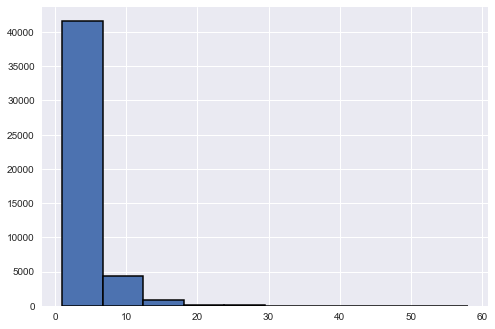

In [450]:
plt.style.use('seaborn')
df['length'].hist(edgecolor='black', lw=1.5)
#round(df.length.value_counts(normalize=True)*100,2)

We __should__ worry that it's not a fully representative sample. Most of the descriptions in the full corpus are shorter, and a large proportion are longer. So this dataset is mainly for debugging, development, and general hill-climbing. All findings should be validated on the full dataset at some point.

## Dev dataset

The first step is to extract the raw color and raw texts from the corpus:

In [7]:
dev_rawcols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])
len(dev_rawcols), len(dev_texts)

(13890, 13890)

In [8]:
processed_texts = pd.read_csv('data/colors/processed_texts.csv')
#processed_texts.head()

In [9]:
pro_texts = [item[0] for item in processed_texts.values.tolist()]
len(dev_texts), len(pro_texts)


(13890, 13890)

The raw color representations are suitable inputs to a model, but the texts are just strings, so they can't really be processed as-is. Question 1 asks you to do some tokenizing!

## Random train–test split for development

For the sake of development runs, we create a random train–test split:

In [8]:
#dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test = train_test_split(dev_rawcols, dev_texts)

In [13]:
def tts(X, y):
    trainx, devx, trainy, devy = train_test_split(X,y)
    print(len(trainx), len(devx), len(trainy), len(devy))
    return trainx, devx, trainy, devy

In [14]:
dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test = tts(dev_rawcols, pro_texts)

10417 3473 10417 3473


In [15]:
#checker to ensure lengths of colors all equal 3
count = 0
for color in dev_rawcols:
    if len(color) != 3:
        count += 1
count

0

## Question 1: Improve the tokenizer [1 point]

This is the first required question – the first required modification to the default pipeline.

The function `tokenize_example` simply splits its string on whitespace and adds the required start and end symbols:

In [16]:
'''
3) replacing tokens that appear once or
not at all in the training split with <unk>.
'''

'\n3) replacing tokens that appear once or\nnot at all in the training split with <unk>.\n'

In [17]:
#preprocessing functions for finding single-item words in training set
from collections import Counter
import re
ish_pattern = '\w+ish'
pattern = '\w+'

bow = []
for item in dev_texts_train + dev_texts_test:
    item = item.lower()
    words = re.findall(pattern, item)
    for word in words:
        bow.append(word)

#full vocab with counts
vocab = Counter(bow)
#sorted full vocab
sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
#ones values 
ones = {k:v for k, v in vocab.items() if v==1 }

In [18]:
percent_ones = np.round(len(ones)/len(vocab), 3)
purples = [k for k in ones if k.startswith('p')]
yellows = [k for k in ones if k.startswith('y')]
blues = [k for k in ones if k.startswith('b')]

In [19]:
import re

def tokenize_example(s: str, ones: dict=ones, vocab: dict=vocab, suffs = ['er', 'est', 'ish']):
    '''
    Tokenizes string example and returns tokens with starting and ending tokens.
    Params: 
        s = string example
        ones = Predefined vocabulary dictionary of words appearing only once in corpus.
        suffs = Predefined suffix values that you would like to split on.
    '''
    
    unk = 'UNK_SYMBOL'
    suffixes = ['er', 'est', 'ish']
    
    #lowercase all words
    s = s.lower()
    
    #remove all punctuation
    words = re.findall('\w+', s)
    
    #replace instances of words appearing only once in vocab dictionary with UNK_SYMBOL
    words = [word.replace(word, unk) if word in ones or word not in vocab else word for word in words]
    final_words = []
    suffixes = tuple(suffs)
    
    for word in words:
        if word.endswith(suffixes):
            for suffix in suffixes:
                if word.endswith(suffix):
                    prefix = word.replace(suffix, '')
                    final_words.append(prefix)
                    final_words.append(suffix)
        else:
            final_words.append(word)
            
    return [START_SYMBOL] + final_words + [END_SYMBOL]

In [20]:
tokenize_example('brightest blue ### brighter than other nonsenseword dinosaur nonsensicalword')

['<s>',
 'bright',
 'est',
 'blue',
 'bright',
 'er',
 'than',
 'oth',
 'er',
 'UNK_SYMBOL',
 'UNK_SYMBOL',
 'UNK_SYMBOL',
 '</s>']

__Your task__: Modify `tokenize_example` so that it does something more sophisticated with the input text. 

__Notes__:

* There are useful ideas for this in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142)
* There is no requirement that you do word-level tokenization. Sub-word and multi-word are options.
* This question can interact with the size of your vocabulary (see just below), and in turn with decisions about how to use `UNK_SYMBOL`.

__Important__: don't forget to add the start and end symbols, else the resulting models will definitely be terrible! The following test will check that your tokenizer has this property:

In [21]:
def test_tokenize_example(func):
    s = "A test string"
    result = func(s)
    assert all(isinstance(tok, str) for tok in result), \
        "The tokenizer must return a list of strings."
    assert result[0] == START_SYMBOL, \
        "The tokenizer must add START_SYMBOL as the first token."
    assert result[-1] == END_SYMBOL, \
        "The tokenizer must add END_SYMBOL as the final token."

In [22]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_tokenize_example(tokenize_example)

## Use the tokenizer

Once the tokenizer is working, run the following cell to tokenize your inputs:

In [23]:
dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]

dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]

We use only the train set to derive a vocabulary for the model:

In [24]:
dev_vocab = sorted({w for toks in dev_seqs_train for w in toks})

dev_vocab += [UNK_SYMBOL]
len(dev_vocab)

457

It's important that the `UNK_SYMBOL` is included somewhere in this list. In test examples, words not seen in training will be mapped to `UNK_SYMBOL`. 

Conceptual note: If you model's vocab is the same as your train vocab, then `UNK_SYMBOL` will never be encountered during training, so it will be a random vector at test time.

In [25]:
len(dev_vocab), len(dev_seqs_train)

(457, 10417)

## Question 2: Improve the color representations [1 point]

This is the second required pipeline improvement for the assignment. 

The following functions do nothing at all to the raw input colors we get from the corpus. 

In [29]:
RANGES_RGB = (256.0, 256.0, 256.0)
RANGES_HSV = (361.0, 101.0, 101.0)
C_EPSILON = 1e-4
    
class ColorVectorizer(object):
    
    def vectorize_all(self, colors, hsv=None):
        '''
        :param colors: A sequence of length-3 vectors or 1D array-like objects containing
                      RGB coordinates in the range [0, 256).
        :param bool hsv: If `True`, input is assumed to be in HSV space in the range
                         [0, 360], [0, 100], [0, 100]; if `False`, input should be in RGB
                         space in the range [0, 256). `None` (default) means take the
                         color space from the value given to the constructor.
        :return np.ndarray: An array of the vectorized form of each color in `colors`
                            (first dimension is the index of the color in the `colors`).
        >>> BucketsVectorizer((2, 2, 2)).vectorize_all([(0, 0, 0), (255, 0, 0)])
        array([0, 4], dtype=int32)
        '''
        return np.array([self.vectorize(c, hsv=hsv) for c in colors])
    

class FourierVectorizer(ColorVectorizer):
    '''
    Vectorizes colors by converting them to a truncated frequency representation.
    This vectorizer can only vectorize, not unvectorize.
    '''
    def __init__(self, resolution, hsv=False):
        '''
        :param resolution: The number of dimensions to truncate the frequency
                           representation (the vectorized representation will be
                           *twice* this, because the frequency representation uses
                           complex numbers). Should be an even number between 0 and
                           the range of each internal color space dimension, or a
                           length-3 sequence of such numbers.
                           
        :param bool hsv: If `True`, the internal color space used by the vectorizer
                         will be HSV. Input and output color spaces can be configured
                         on a per-call basis by using the `hsv` parameter of
                         `vectorize` and `unvectorize`.
        '''
        if len(resolution) == 1:
            resolution = resolution * 3
        self.resolution = resolution
        self.output_size = np.prod(resolution) * 2
        self.hsv = hsv

    def vectorize(self, color, hsv=None):
        '''
        :param color: An length-3 vector or 1D array-like object containing
                      color coordinates.
        :param bool hsv: If `True`, input is assumed to be in HSV space in the range
                         [0, 360], [0, 100], [0, 100]; if `False`, input should be in RGB
                         space in the range [0, 255]. `None` (default) means take the
                         color space from the value given to the constructor.
        :return np.ndarray: The color in the Fourier representation,
                            a vector of shape `(prod(resolution) * 2,)`.
        >>> normalize = lambda v: np.where(v.round(2) == 0.0, 0.0, v.round(2))
        >>> normalize(FourierVectorizer([2]).vectorize((255, 0, 0)))
        array([ 1.,  1.,  1.,  1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,
                0.,  0.,  0.], dtype=float32)
        >>> normalize(FourierVectorizer([2]).vectorize((180, 100, 100), hsv=True))
        array([ 1., -1., -1.,  1.,  1., -1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,
                0.,  0.,  0.], dtype=float32)
        >>> normalize(FourierVectorizer([2], hsv=True).vectorize((0, 100, 100)))
        array([ 1., -1., -1.,  1.,  1., -1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,
                0.,  0.,  0.], dtype=float32)
        >>> normalize(FourierVectorizer([2], hsv=True).vectorize((0, 255, 255), hsv=False))
        array([ 1., -1., -1.,  1., -1.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,
                0.,  0.,  0.], dtype=float32)
        '''
        return self.vectorize_all([color], hsv=hsv)[0]

    def vectorize_all(self, colors, hsv=None):
        '''
        >>> normalize = lambda v: np.where(v.round(2) == 0.0, 0.0, v.round(2))
        >>> normalize(FourierVectorizer([2]).vectorize_all([(255, 0, 0), (0, 255, 255)]))
        array([[ 1.,  1.,  1.,  1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,
                 0.,  0.,  0.],
               [ 1., -1., -1.,  1.,  1., -1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,
                 0.,  0.,  0.]], dtype=float32)
        '''
        if hsv is None:
            hsv = self.hsv

        colors = np.array([colors])
        assert len(colors.shape) == 3, colors.shape
        assert colors.shape[2] == 3, colors.shape

        ranges = np.array(RANGES_HSV if self.hsv else RANGES_RGB)
        if hsv and not self.hsv:
            c_hsv = colors
            color_0_1 = skimage.color.hsv2rgb(c_hsv / (np.array(RANGES_HSV) - 1.0))
        elif not hsv and self.hsv:
            c_rgb = colors
            color_0_1 = skimage.color.rgb2hsv(c_rgb / (np.array(RANGES_RGB) - 1.0))
        else:
            color_0_1 = colors / (ranges - 1.0)

        # Using a Fourier representation causes colors at the boundary of the
        # space to behave as if the space is toroidal: red = 255 would be
        # about the same as red = 0. We don't want this...
        xyz = color_0_1[0] / 2.0
        if self.hsv:
            # ...*except* in the case of HSV: H is in fact a polar coordinate.
            xyz[:, 0] *= 2.0

        # ax, ay, az = [np.hstack([np.arange(0, g / 2), np.arange(r - g / 2, r)])
        #               for g, r in zip(self.resolution, ranges)]
        ax, ay, az = [np.arange(0, g) for g, r in zip(self.resolution, ranges)]
        gx, gy, gz = np.meshgrid(ax, ay, az)

        arg = (np.multiply.outer(xyz[:, 0], gx) +
               np.multiply.outer(xyz[:, 1], gy) +
               np.multiply.outer(xyz[:, 2], gz))
        assert arg.shape == (xyz.shape[0],) + tuple(self.resolution), arg.shape
        repr_complex = np.exp(-2j * np.pi * (arg % 1.0)).swapaxes(1, 2).reshape((xyz.shape[0], -1))
        result = np.hstack([repr_complex.real, repr_complex.imag]).astype(np.float32)
        return result


In [40]:
def represent_color_context(colors):
    return [represent_color(color) for color in colors]


def represent_color(color: list) -> np.array:
    '''
    Given an input list of floats in HSL format, converts input
    into a numpy array in HSV format.
    '''
    
    f = FourierVectorizer([3],hsv=True)

    #convert HLS to HSV
    arr = np.array(color)
    hue = arr[0]
    sat = arr[1]/100
    lum = arr[2]/100
    arr[0] = hue
    value = lum + sat * min(lum, 1.0-lum)
    arr[2] = value * 100
    Sv = np.where(value == 0, 0, 2*(1 - lum/value))
    arr[1] = Sv * 100
    transform = f.vectorize(arr, hsv=True)
    transform = [float(x) for x in transform]
    
    return transform

The following test seeks to ensure only that the output of your `represent_color_context` will be compatible with the models we are creating:

In [41]:
def test_represent_color_context(func):
    """`func` should be `represent_color_context`"""
    example = [
        [0.786, 0.58, 0.87],
        [0.689, 0.44, 0.92],
        [0.628, 0.32, 0.81]]
    result = func(example)
    assert len(result) == len(example), \
        ("Color context representations need to represent each color "
         "separately. (We assume the final color is the target.)")
    for i, color in enumerate(result):
        assert all(isinstance(x, float) for x in color), \
            ("All color representations should be lists of floats. "
             "Color {} is {}".format(i, color))

In [42]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_represent_color_context(represent_color_context)

## Use the color representer

The following cell just runs your `represent_color_context` on the train and test sets:

In [43]:
dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]

dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]

list(map(len, [dev_cols_train, dev_cols_test]))

/var/folders/vz/y69dc7vd1b33fg5qvfg3vnrr0000gp/T/ipykernel_19069/3637270439.py:21: RuntimeWarning: invalid value encountered in double_scalars
  Sv = np.where(value == 0, 0, 2*(1 - lum/value))


[10417, 3473]

At this point, our preprocessing steps are complete, and we can fit a first model.

## Initial model

The first model is configured right now to be a small model run for just a few iterations. It should be enough to get traction, but it's unlikely to be a great model. You are free to modify this configuration if you wish; it is here just for demonstration and testing:

In [45]:
dev_mod = ContextualColorDescriber(
    dev_vocab,
    early_stopping=True)

In [46]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    %time _ = dev_mod.fit(dev_cols_train, dev_seqs_train)
else:
    dev_mod.fit(dev_cols_train, dev_seqs_train)

/Users/americanthinker1/Training/cs224u/torch_color_describer.py:91: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  color_seqs = torch.FloatTensor(color_seqs)
Stopping after epoch 75. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 29.481767416000366

CPU times: user 4min 44s, sys: 2min 6s, total: 6min 50s
Wall time: 3min 22s


The canonical bake-off evaluation function is `evaluate`. Our primary metric is `listener_accuracy`; the BLEU score is included as a check to ensure that your system is speaking English!

In [47]:
evaluation = dev_mod.evaluate(dev_cols_test, dev_seqs_test)

In [48]:
evaluation.keys()

dict_keys(['listener_accuracy', 'corpus_bleu', 'target_index', 'predicted_index', 'predicted_utterance'])

In [49]:
evaluation['listener_accuracy']

0.8053556003455226

In [50]:
dev_mod.listener_accuracy(dev_cols_test, dev_seqs_test)

0.8053556003455226

In [51]:
evaluation['corpus_bleu']

0.7055105231165629

In [52]:
bleu, predicted_utterances = dev_mod.corpus_bleu(dev_cols_test, dev_seqs_test)

bleu

0.7055105231165629

In [53]:
evaluation['target_index'][: 5]

[2, 2, 2, 2, 2]

In [54]:
evaluation['predicted_index'][: 5]

[2, 0, 2, 0, 2]

In [55]:
evaluation['predicted_utterance'][:5]

[['<s>', 'bright', 'purple', '</s>'],
 ['<s>', 'yellow', 'green', '</s>'],
 ['<s>', 'dark', 'er', 'purple', '</s>'],
 ['<s>', 'bright', 'pink', '</s>'],
 ['<s>', 'bright', 'green', '</s>']]

We can also see the model's predicted sequences given color context inputs:

In [58]:
dev_mod.predict(dev_cols_test[: 1])

[['<s>', 'bright', 'purple', '</s>']]

In [59]:
dev_seqs_test[: 1]

[['<s>', 'right', 'side', 'purple', 'pink', 'ish', '</s>']]

## Question 3: GloVe embeddings [1 point]

The above model uses a random initial embedding, as configured by the decoder used by `ContextualColorDescriber`. This homework question asks you to consider using GloVe inputs. 

__Your task__: Complete `create_glove_embedding` so that it creates a GloVe embedding based on your model vocabulary. This isn't mean to be analytically challenging, but rather just to create a basis for you to try out other kinds of rich initialization.

In [60]:
GLOVE_HOME = os.path.join('data/', 'glove.6B')

In [61]:
def create_glove_embedding(vocab, glove_base_filename='glove.6B.50d.txt'):

    # Use `utils.glove2dict` to read in the GloVe file:
    path = os.path.join(GLOVE_HOME, glove_base_filename)
    glove_embeddings = utils.glove2dict(path)
    

    # Use `utils.create_pretrained_embedding` to create the embedding.
    # This function will, by default, ensure that START_TOKEN,
    # END_TOKEN, and UNK_TOKEN are included in the embedding.
    embed = utils.create_pretrained_embedding(glove_embeddings, vocab)


    # Be sure to return the embedding you create as well as the
    # vocabulary returned by `utils.create_pretrained_embedding`,
    # which is likely to have been modified from the input `vocab`.
    
    return embed[0], embed[1]


In [62]:
data = create_glove_embedding(dev_vocab)

In [63]:
d = {v:k for k,v in zip(data[0], data[1])}

In [64]:
def test_create_glove_embedding(func):
    vocab = ['NLU', 'is', 'the', 'future', '.', '$UNK', '<s>', '</s>']
    glove_embedding, glove_vocab = func(vocab, 'glove.6B.50d.txt')
    assert isinstance(glove_embedding, np.ndarray), \
        "Expected embedding type {}; got {}".format(
        glove_embedding.__class__.__name__, glove_embedding.__class__.__name__)
    assert glove_embedding.shape == (8, 50), \
        "Expected embedding shape (8, 50); got {}".format(glove_embedding.shape)
    assert glove_vocab == vocab, \
        "Expected vocab {}; got {}".format(vocab, glove_vocab)

In [65]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_create_glove_embedding(create_glove_embedding)

## Try the GloVe representations

The extent to which GloVe is useful will depend heavily on how aligned your tokenization scheme is with the GloVe vocabulary. For example, if you did character-level tokenization, then the GloVe embedding space is not well-aligned with your tokenizer and using GloVe should have little no positive effect.

Let's see if GloVe helped for our development data:

In [75]:
dev_glove_embedding, dev_glove_vocab = create_glove_embedding(dev_vocab, glove_base_filename='glove.6B.300d.txt')

In [76]:
len(dev_vocab)

457

In [77]:
len(dev_glove_vocab)

457

In [78]:
dev_mod_glove = ContextualColorDescriber(
    dev_glove_vocab,
    embedding=dev_glove_embedding,
    early_stopping=True, 
    )

In [79]:
_ = dev_mod_glove.fit(dev_cols_train, dev_seqs_train)

Stopping after epoch 104. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 26.71087646484375

In [80]:
dev_mod_glove.listener_accuracy(dev_cols_test, dev_seqs_test)

0.8139936654189461

In [82]:
result = dev_mod_glove.corpus_bleu(dev_cols_test, dev_seqs_test)
result[0]

0.7036917815954726

You probably saw a small boost, assuming your tokeization scheme leads to good overlap with the GloVe vocabulary. The input representations are larger than in our previous model (at least as I configured things), so we would need to do more runs with higher `max_iter` values to see whether this is worthwhile overall.

## Question 4: Color context [3 points]

The final required homework question is the most challenging, but it should set you up to think in much more flexible ways about the underlying model we're using.

The question asks you to modify various model components in `torch_color_describer.py`. The section called [Modifying the core model](colors_overview.ipynb#Modifying-the-core-model) from the core unit notebook provides a number of examples illustrating the basic techniques, so you might review that material if you get stuck here.

__Your task__: Building on ideas from [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142), you will redesign the model so that the target color (the final one in the context) is appended to each input token that gets processed by the decoder. The question asks you to subclass the `Decoder` and `EncoderDecoder` from `torch_color_describer.py` so that you can build models that do this.

__Step 1__: Modify the `Decoder` so that the input vector to the model at each timestep is not just a token representation `x` but the concatenation of `x` with the representation of the target color.

__Notes__:

* You might notice at this point that the original `Decoder.forward` method has an optional keyword argument `target_colors` that is passed to `Decoder.get_embeddings`. Because this is already in place, all you have to do is modify the `get_embeddings` method to use this argument.

* The change affects the configuration of `self.rnn`, so you need to subclass the `__init__` method as well, so that its `input_size` argument accomodates the embedding as well as the color representations.

* You can do the relevant operations efficiently in pure PyTorch using `repeat_interleave` and `cat`, but the important thing is to get a working implementation – you can always optimize the code later if the ideas prove useful to you. 

Here's skeleton code for you to flesh out:

In [ ]:
from torch_color_describer import Decoder
import torch
import torch.nn as nn


class ColorContextDecoder(Decoder):
    def __init__(self, color_dim, *args, **kwargs):
        self.color_dim = color_dim
        super().__init__(*args, **kwargs)

        # Fix the `self.rnn` attribute:
        ##### YOUR CODE HERE


    def get_embeddings(self, word_seqs, target_colors=None):
        """
        You can assume that `target_colors` is a tensor of shape
        (m, n), where m is the length of the batch (same as
        `word_seqs.shape[0]`) and n is the dimensionality of the
        color representations the model is using. The goal is
        to attached each color vector i to each of the tokens in
        the ith sequence of (the embedded version of) `word_seqs`.

        """
        ##### YOUR CODE HERE



Step 1 is the most demanding of the steps in terms of tensor wrangling. It's important to have a clear idea of what you are trying to achieve and to unit test `get_embeddings` so that you can check that it has realized your vision. The following test should help with that:

In [ ]:
def test_get_embeddings(decoder_class):
    """
    It's assumed that the input to this will be `ColorContextDecoder`.
    You pass in the class, and the function initalizes it with the test
    parameters.
    """
    dec = decoder_class(
        color_dim=3,   # For these, we mainly want *different*
        vocab_size=10, # dimensions so that we reliably get
        embed_dim=4,   # dimensionality errors if something
        hidden_dim=5)  # isn't working.

    # This step just changes the embedding to one with values
    # that are easy to inspect and definitely will not change
    # between runs:
    dec.embedding = nn.Embedding.from_pretrained(
        torch.FloatTensor([
            [10, 11, 12, 13],
            [14, 15, 16, 17],
            [18, 19, 20, 21]]))

    # These are the incoming sequences -- lists of indices
    # into the rows of `dec.embedding`:
    word_seqs = torch.tensor([
        [0,1,2],
        [2,0,1]])

    # Target colors as small floats that will be easy to track:
    target_colors = torch.tensor([
        [0.1, 0.2, 0.3],
        [0.7, 0.8, 0.9]])

    # The desired return value: one list of tensors for each of
    # the two sequences in `word_seqs`. Each index is replaced
    # with its vector from `dec.embedding` and has the
    # corrresponding color from `target_colors` appended to it.
    expected = torch.tensor([
        [[10., 11., 12., 13.,  0.1,  0.2,  0.3],
         [14., 15., 16., 17.,  0.1,  0.2,  0.3],
         [18., 19., 20., 21.,  0.1,  0.2,  0.3]],

        [[18., 19., 20., 21.,  0.7,  0.8,  0.9],
         [10., 11., 12., 13.,  0.7,  0.8,  0.9],
         [14., 15., 16., 17.,  0.7,  0.8,  0.9]]])

    result = dec.get_embeddings(word_seqs, target_colors=target_colors)

    assert expected.shape == result.shape, \
        "Expected shape {}; got shape {}".format(expected.shape, result.shape)

    assert torch.all(expected.eq(result)), \
        ("Your result has the desired shape but the values aren't correct. "
         "Here's what your function creates; compare it with `expected` "
         "from the test:\n{}".format(result))

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_get_embeddings(ColorContextDecoder)

__Step 2__: Modify the `EncoderDecoder`. For this, you just need to make a small change to the `forward` method: extract the target colors from `color_seqs` and feed them to the decoder.

In [ ]:
from torch_color_describer import EncoderDecoder

class ColorizedEncoderDecoder(EncoderDecoder):

    def forward(self,
            color_seqs,
            word_seqs,
            seq_lengths=None,
            hidden=None,
            targets=None):
        if hidden is None:
            hidden = self.encoder(color_seqs)

        # Extract the target colors from `color_seqs` and
        # feed them to the decoder, which already has a
        # `target_colors` keyword.

        ##### YOUR CODE HERE



        # Your decoder will return `output, hidden` pairs; the
        # following will handle the two return situations that
        # the code needs to consider -- training and prediction.
        if self.training:
            return output
        else:
            return output, hidden

__Step 3__: Finally, as in the examples in [Modifying the core model](colors_overview.ipynb#Modifying-the-core-model), you need to modify the `build_graph` method of `ContextualColorDescriber` so that it uses your new `ColorContextDecoder` and `ColorizedEncoderDecoder`. Here's starter code:

In [ ]:
from torch_color_describer import Encoder

class ColorizedInputDescriber(ContextualColorDescriber):

    def build_graph(self):

        # We didn't modify the encoder, so this is
        # just copied over from the original:
        encoder = Encoder(
            color_dim=self.color_dim,
            hidden_dim=self.hidden_dim)

        # Use your `ColorContextDecoder`, making sure
        # to pass in all the keyword arguments coming
        # from `ColorizedInputDescriber`:

        ##### YOUR CODE HERE



        # Return a `ColorizedEncoderDecoder` that uses
        # your encoder and decoder:

        ##### YOUR CODE HERE



That's it! Since these modifications are pretty intricate, you might want to use [a toy dataset](colors_overview.ipynb#Toy-problems-for-development-work) to debug it:

In [ ]:
def test_full_system(describer_class):
    toy_color_seqs, toy_word_seqs, toy_vocab = create_example_dataset(
        group_size=50, vec_dim=2)

    toy_color_seqs_train, toy_color_seqs_test, toy_word_seqs_train, toy_word_seqs_test = \
        train_test_split(toy_color_seqs, toy_word_seqs)

    toy_mod = describer_class(toy_vocab)

    _ = toy_mod.fit(toy_color_seqs_train, toy_word_seqs_train)

    acc = toy_mod.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

    return acc

In [ ]:
test_full_system(ColorizedInputDescriber)

If that worked, then you can now try this model on SCC problems!

## Your original system [3 points]

There are many options for your original system, which consists of the full pipeline – all preprocessing and modeling steps. You are free to use any model you like, as long as you subclass `ContextualColorDescriber` in a way that allows its `evaluate` method to behave in the expected way.

So that we can evaluate models in a uniform way for the bake-off, we ask that you modify the function `evaluate_original_system` below so that it accepts a trained instance of your model and does any preprocessing steps required by your model.

If we seek to reproduce your results, we will rerun this entire notebook. Thus, it is fine if your `evaluate_original_system` makes use of functions you wrote or modified above this cell.

In [ ]:
def evaluate_original_system(trained_model, color_seqs_test, texts_test):
    """
    Feel free to modify this code to accommodate the needs of
    your system. Just keep in mind that it will get raw corpus
    examples as inputs for the bake-off.

    """
    # `word_seqs_test` is a list of strings, so tokenize each of
    # its elements:
    tok_seqs = [tokenize_example(s) for s in texts_test]

    col_seqs = [represent_color_context(colors)
                for colors in color_seqs_test]


    # Optionally include other preprocessing steps here. Note:
    # DO NOT RETRAIN YOUR MODEL AS PART OF THIS EVALUATION!
    # It's a tempting step, but it's a mistake and will get
    # you disqualified!

    # The following core score calculations are required:
    evaluation = trained_model.evaluate(col_seqs, tok_seqs)

    return evaluation

If `evaluate_original_system` works on test sets you create from the corpus distribution, then it will work for the bake-off, so consider checking that. For example, this would check that `dev_mod` above passes muster:

In [ ]:
my_evaluation = evaluate_original_system(dev_mod, dev_rawcols_test, dev_texts_test)

In [ ]:
my_evaluation['listener_accuracy']

In [ ]:
my_evaluation['corpus_bleu']

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies. We also ask that you report the best **listener_accuracy** score your system got during development, just to help us understand how systems performed overall.

<font color='red'>Please review the descriptions in the following comment and follow the instructions.</font>

In [ ]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
#   3) The score achieved by your system in place of MY_NUMBER.
#        With no other changes to that line.
#        You should report your score as a decimal value <=1.0
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# NOTE: MODULES, CODE AND DATASETS REQUIRED FOR YOUR ORIGINAL SYSTEM
# SHOULD BE ADDED BELOW THE 'IS_GRADESCOPE_ENV' CHECK CONDITION. DOING
# SO ABOVE THE CHECK MAY CAUSE THE AUTOGRADER TO FAIL.

# START COMMENT: Enter your system description in this cell.
# My peak score was: MY_NUMBER
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass

# STOP COMMENT: Please do not remove this comment.

## Bakeoff [1 point]

For the bake-off, we will use our original test set. The function you need to run for the submission is the following, which uses your `evaluate_original_system` from above:

In [ ]:
def create_bakeoff_submission(
        trained_model,
        output_filename='cs224u-colors-bakeoff-entry.csv'):
    bakeoff_src_filename = os.path.join(
        "data", "colors", "cs224u-colors-test.csv")

    bakeoff_corpus = ColorsCorpusReader(bakeoff_src_filename)

    # This code just extracts the colors and texts from the new corpus:
    bakeoff_rawcols, bakeoff_texts = zip(*[
        [ex.colors, ex.contents] for ex in bakeoff_corpus.read()])

    # Original system function call; `trained_model` is your trained model:
    evaluation = evaluate_original_system(
        trained_model, bakeoff_rawcols, bakeoff_texts)

    evaluation['bakeoff_text'] = bakeoff_texts

    df = pd.DataFrame(evaluation)
    df.to_csv(output_filename)

In [ ]:
# This check ensure that the following code only runs on the local environment only.
# The following call will not be run on the autograder environment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    create_bakeoff_submission(dev_mod)

This creates a file `cs224u-colors-bakeoff-entry.csv` in the current directory. That file should be uploaded as-is. Please do not change its name.

Only one upload per team is permitted, and you should do no tuning of your system based on what you see in the file – you should not study that file in anyway, beyond perhaps checking that it contains what you expected it to contain. The upload function will do some additional checking to ensure that your file is well-formed.

The nature of our evaluation is such that we have to release the full test set with all labels. Thus, we have to trust you not to make any use of the test set during development. Recall:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.

Systems will be ranked primarily by `listener_accuracy`, but we will also consider their `corpus_bleu` scores. However, the BLEU score is just a simple check that your system is speaking some version of English that corresponds in some meaningful way to the gold descriptions, so you should concentrate on `listener_accuracy`.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points.

## Submission Instruction

Review and follow the [Homework and bake-off code: Formatting guide](hw_formatting_guide.ipynb).
Please do not change the file name as described below.

Submit the following files to Gradescope:

- `hw_colors.ipynb` (this notebook)
- `cs224u-colors-bakeoff-entry.csv` (bake-off output)